# Travelling Salesperson with Capacities Example

Lucerne University of Applied Sciences and Arts - School of Information Technology

Code adapted from https://developers.google.com/optimization/routing/tsp/tsp

@author: Tobias Mérinat
@author: Marc Pouly

Imports

In [32]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from tsp_examples import large_capa, manhattan_capa

Choose example

In [33]:
example = manhattan_capa

Assign values

In [34]:
city_names = example.names
distance = example.distance
num_cities = example.num_cities
num_vehicles = example.num_vehicles
depot_index = example.depot_index  
#demand = example.demand
capacities = example.capacities

print("Cities:", list(city_names))
print("Demand per City:",  list(example.demands))
print("Vehicles:", num_vehicles)
print("Depot:", depot_index)
print("Vehicle Capacities:", capacities)


# Nodes are indexed from 0 to tsp_size - 1. The depot is the starting node of the route.

# The above input numbers are being imported from an external file.
# Uncomment the following lines for experimenting

#demands = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]

#num_vehicles = 4

#def demand(a, _):
#    return demands[a]

#capacities = [15] * num_vehicles

Cities: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Demand per City: [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
Vehicles: 4
Depot: 0
Vehicle Capacities: [15, 15, 15, 15]


Create routing model

In [35]:
routing = pywrapcp.RoutingModel(num_cities, num_vehicles, depot_index)

All vehicles use the same cost model

In [36]:
routing.SetArcCostEvaluatorOfAllVehicles(distance)

Capacity constraints, the 0 means that capacities are strict

In [37]:
routing.AddDimensionWithVehicleCapacity(demand, 0, capacities, True, "capacity")

True

Configure solver

In [38]:
parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
parameters.time_limit_ms = 10000

Start solver

In [39]:
assignment = routing.SolveWithParameters(parameters)

Print solution

In [40]:
if assignment:
    print('Total distance: {} miles, demands of each city in parenthesis\n'.format(assignment.ObjectiveValue()))
    for vehicle_num in range(routing.vehicles()):
        print('"Vehicle" {} (capacity {}):'.format(vehicle_num+1, capacities[vehicle_num]))
        route = ""
        var_index = routing.Start(vehicle_num)  # index of the variable for the starting node
        while not routing.IsEnd(var_index):
            # Convert variable indices to node indices for displaying
            city_index = routing.IndexToNode(var_index)
            route += ' {}({}) -> '.format(city_names[city_index], example.demands[city_index])
            var_index = assignment.Value(routing.NextVar(var_index))
            city_index = routing.IndexToNode(var_index)
            route += '{}({})\n'.format(city_names[city_index], example.demands[city_index])
        print(route)
else:
    print('No solution found.')

Total distance: 64 miles, demands of each city in parenthesis

"Vehicle" 1 (capacity 15):
 0(0) -> 1(1)
 1(1) -> 4(4)
 4(4) -> 3(2)
 3(2) -> 7(8)
 7(8) -> 0(0)

"Vehicle" 2 (capacity 15):
 0(0) -> 13(4)
 13(4) -> 15(8)
 15(8) -> 11(1)
 11(1) -> 12(2)
 12(2) -> 0(0)

"Vehicle" 3 (capacity 15):
 0(0) -> 8(8)
 8(8) -> 2(1)
 2(1) -> 6(4)
 6(4) -> 5(2)
 5(2) -> 0(0)

"Vehicle" 4 (capacity 15):
 0(0) -> 9(1)
 9(1) -> 14(4)
 14(4) -> 16(8)
 16(8) -> 10(2)
 10(2) -> 0(0)



Total distance: 64


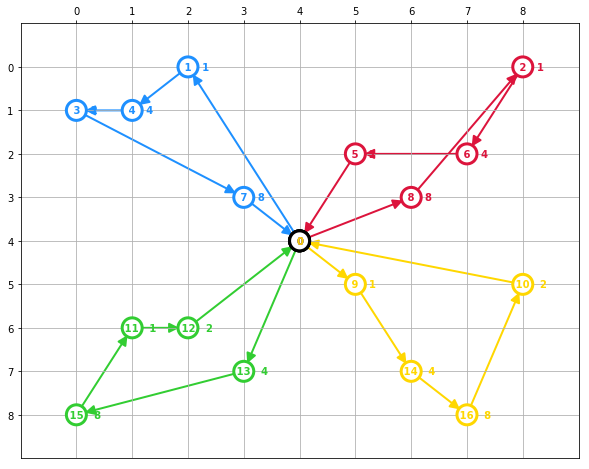

In [41]:
if example==manhattan_capa:
    import networkx as nx
    from itertools import chain
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    nodes = example.nodes
    demands = example.demands

    def make_ax():
        fig, ax = plt.subplots(figsize=(10,8))
        ax.set_xlim(-1, 9)
        ax.set_ylim(9, -1)
        ax.set_xticks([0,1,2,3,4,5,6,7,8])
        ax.set_yticks([8,7,6,5,4,3,2,1,0])
        ax.xaxis.tick_top()
        ax.grid()
        return ax
    
    def plot_manhattan(all_nodes, tour_colors, graphs=None, all_demands=None):
        ax = make_ax()

        for graph, color in zip(graphs, tour_colors):
            G = nx.DiGraph()
            node_indices = list(set(chain.from_iterable(graph)))
            nodes = [all_nodes[i] for i in node_indices]
            demands = [all_demands[i] for i in node_indices]
            pos = {k:v for k, v in zip(node_indices, nodes)}

            G.add_nodes_from(pos.keys())
            G.add_edges_from(graph)

            color_list = ['black'] + [color] * (len(nodes)-1)
            nx.draw_networkx_nodes(G, pos, ax=ax, node_size=400, node_color='white', edgecolors=color_list, linewidths=3)
            nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=20, width=2, edge_color=color)
            labels = {k:"     {}   {}".format(k, d) for k, d in zip(pos.keys(), demands)}
            labels[0] = 0
            nx.draw_networkx_labels(G, pos, labels=labels, ax=ax,
                                    font_color=color, font_size=10, font_weight='bold')
        plt.show()
    
    if assignment:
        graphs = []
        print("Total distance: {}".format(assignment.ObjectiveValue()))
        for vehicle_num in range(routing.vehicles()):
            graph = []
            index = routing.Start(vehicle_num)  # index of the variable for the starting node
            a = routing.IndexToNode(index)
            while not routing.IsEnd(index):
                index = assignment.Value(routing.NextVar(index))
                b = routing.IndexToNode(index)
                graph.append((a,b))
                a = routing.IndexToNode(index)
            graph.append((a, 0))
            graphs.append(graph)
        plot_manhattan(nodes, tour_colors=['dodgerblue', 'limegreen', 'crimson', 'gold'], graphs=graphs, all_demands=demands)